In [79]:
%pylab inline
from collections import OrderedDict
import pickle
import numpy as np
import seaborn as sns
from tqdm import trange
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from scipy.spatial.distance import pdist,squareform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings('ignore') 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load Data

In [17]:
filename = '/om2/user/mabdel03/files/BTI/Moseq/Classifier_Template/moseq-drug-classifier/fingerprints.pkl'

In [24]:
with open(filename, 'rb') as f:
    fingerprints_og, fingerprint_labels_og = pickle.load(f, encoding='latin1')

In [25]:
fingerprints_og

OrderedDict([('position',
              array([[  0,   1,   3, ...,  27,   3,   1],
                     [  0,  13,   9, ...,   0,   0,   0],
                     [ 10,   8,  18, ..., 138,  19,   4],
                     ...,
                     [  1,   2,   4, ...,   0,   0,   0],
                     [  5,  16,  20, ...,  12,   0,   0],
                     [  4,  13,  21, ...,  11,   0,   0]])),
             ('speed',
              array([[12916,  5113,  2855, ...,     0,     0,     0],
                     [10952,  4441,  2696, ...,     0,     0,     0],
                     [10125,  4753,  2872, ...,     0,     0,     0],
                     ...,
                     [11774,  4721,  2616, ...,     0,     1,     0],
                     [ 8173,  4158,  2715, ...,     0,     0,     0],
                     [11171,  5641,  3269, ...,     0,     0,     0]])),
             ('simplepose',
              array([[ 55,  91, 161, ..., 150, 133, 164],
                     [  3,  16,  44, ..

In [26]:
shape(fingerprints_og['position'])

(501, 89)

In [27]:
shape(fingerprints_og['moseq'])

(501, 90)

In [28]:
shape(fingerprint_labels_og['y_drug'])

(501,)

In [5]:
fingerprint_labels

OrderedDict([('y_drug',
              array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                      0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                      0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
                      1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                      1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
                      2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
                      2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
                      3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
                      3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
                      4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
                      5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  

In [115]:
def rename_groups(df):
    
    """
    Function that takes a dataframe as input
    Returns the same dataframe but with a new category column
    Category column contains updated group labels accounting for different controls
    """
    
    new_cat = []
    
    for row in df.index:
        """
        if df['group'][row].split('_')[0] == 'NGH':
            NGHtype = uuid_NameMap[df['uuid'][row]]
            if NGHtype.split('_')[-1].startswith('05'):
                new_cat.append('Ctrl-LNB')
            elif NGHtype.split('_')[-1].startswith('03'):
                new_cat.append('Ctrl-EE/SI')
        else:
        """
        new_cat.append(df['group'][row].split('_')[0])

    df['category'] = new_cat
    
    return df

In [116]:
def reformat_df(subset_df, metric_interest):
    """
    Take multi-index summary dataframe from Moseq fingerprint code as well as a metric of interest
    Reformat into single index dataframe for further analysis
    Returns dataframe with category label, position, uuid, and avg_time for that uuid in that metric
    """

    category = []
    position = []
    uuid_num = []
    avg_time = []
    
    for ix in subset_df[metric_interest]:
        for cat, uuid in subset_df[metric_interest][ix].index:
            category.append(cat)
            position.append(ix)
            uuid_num.append(uuid)
            avg_time.append(subset_df[metric_interest][ix][cat][uuid])
    
    
    return rename_groups(pd.DataFrame(data={'group': category, 'Metric': position, 'uuid': uuid_num, 'avg_time': avg_time}))


In [117]:
summary_df = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Fingerprints/DFs/Full/summary.csv', index_col=[0, 1], header=[0, 1])
range_dict = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Fingerprints/DFs/Full/range_dict.csv')

In [118]:
Moms_df = summary_df[summary_df.index.get_level_values('group').str.contains('Mom')]

In [119]:
m_pos_df = reformat_df(Moms_df, 'dist_to_center_px')
m_height_df = reformat_df(Moms_df, 'height_ave_mm')
m_length_df = reformat_df(Moms_df, 'length_mm')
m_vel_df = reformat_df(Moms_df, 'velocity_2d_mm')
m_moseq_df = reformat_df(Moms_df, 'MoSeq')

In [120]:
m_pos_df

,group,Metric,uuid,avg_time,category
0,LNB_Mom_Female,0,12fc2b40-79c3-45fc-862d-3a4a770676bd,0.000111,LNB
1,LNB_Mom_Female,0,2bf96938-6122-49c7-b250-b94322c8b762,0.000139,LNB
2,LNB_Mom_Female,0,50fd9290-c498-4ca2-9929-49a38b6c8ffb,0.000056,LNB
3,LNB_Mom_Female,0,65a73784-3905-4022-a7ec-8b608e42f823,0.000056,LNB
4,LNB_Mom_Female,0,9e157199-4e46-4856-9989-7b5502504fa2,0.000139,LNB
...,...,...,...,...,...
1084,NGH_Mom_Female,98,01b7b197-f8e9-4cc8-934a-9652d1746229,0.000000,NGH
1085,NGH_Mom_Female,98,0650491b-b1e2-4672-8db2-b9fd33212de2,0.000000,NGH
1086,NGH_Mom_Female,98,14f65e3b-f058-4657-81a6-35e5e4cbd5fe,0.000000,NGH
1087,NGH_Mom_Female,98,b192a588-2324-4254-9db5-01a17f4f67dc,0.000000,NGH


In [21]:
m_height_df

,group,Metric,uuid,avg_time,category
0,LNB_Mom_Female,0,12fc2b40-79c3-45fc-862d-3a4a770676bd,0.000306,LNB
1,LNB_Mom_Female,0,2bf96938-6122-49c7-b250-b94322c8b762,0.000028,LNB
2,LNB_Mom_Female,0,50fd9290-c498-4ca2-9929-49a38b6c8ffb,0.000000,LNB
3,LNB_Mom_Female,0,65a73784-3905-4022-a7ec-8b608e42f823,0.000167,LNB
4,LNB_Mom_Female,0,9e157199-4e46-4856-9989-7b5502504fa2,0.000000,LNB
...,...,...,...,...,...
1084,NGH_Mom_Female,98,01b7b197-f8e9-4cc8-934a-9652d1746229,0.000000,NGH
1085,NGH_Mom_Female,98,0650491b-b1e2-4672-8db2-b9fd33212de2,0.000000,NGH
1086,NGH_Mom_Female,98,14f65e3b-f058-4657-81a6-35e5e4cbd5fe,0.000000,NGH
1087,NGH_Mom_Female,98,b192a588-2324-4254-9db5-01a17f4f67dc,0.000000,NGH


In [22]:
m_length_df

,group,Metric,uuid,avg_time,category
0,LNB_Mom_Female,0,12fc2b40-79c3-45fc-862d-3a4a770676bd,0.0,LNB
1,LNB_Mom_Female,0,2bf96938-6122-49c7-b250-b94322c8b762,0.0,LNB
2,LNB_Mom_Female,0,50fd9290-c498-4ca2-9929-49a38b6c8ffb,0.0,LNB
3,LNB_Mom_Female,0,65a73784-3905-4022-a7ec-8b608e42f823,0.0,LNB
4,LNB_Mom_Female,0,9e157199-4e46-4856-9989-7b5502504fa2,0.0,LNB
...,...,...,...,...,...
1084,NGH_Mom_Female,98,01b7b197-f8e9-4cc8-934a-9652d1746229,0.0,NGH
1085,NGH_Mom_Female,98,0650491b-b1e2-4672-8db2-b9fd33212de2,0.0,NGH
1086,NGH_Mom_Female,98,14f65e3b-f058-4657-81a6-35e5e4cbd5fe,0.0,NGH
1087,NGH_Mom_Female,98,b192a588-2324-4254-9db5-01a17f4f67dc,0.0,NGH


In [23]:
m_moseq_df

,group,Metric,uuid,avg_time,category
0,LNB_Mom_Female,0,12fc2b40-79c3-45fc-862d-3a4a770676bd,0.027136,LNB
1,LNB_Mom_Female,0,2bf96938-6122-49c7-b250-b94322c8b762,0.044948,LNB
2,LNB_Mom_Female,0,50fd9290-c498-4ca2-9929-49a38b6c8ffb,0.045667,LNB
3,LNB_Mom_Female,0,65a73784-3905-4022-a7ec-8b608e42f823,0.007920,LNB
4,LNB_Mom_Female,0,9e157199-4e46-4856-9989-7b5502504fa2,0.000000,LNB
...,...,...,...,...,...
655,NGH_Mom_Female,59,01b7b197-f8e9-4cc8-934a-9652d1746229,0.000000,NGH
656,NGH_Mom_Female,59,0650491b-b1e2-4672-8db2-b9fd33212de2,0.000000,NGH
657,NGH_Mom_Female,59,14f65e3b-f058-4657-81a6-35e5e4cbd5fe,0.000000,NGH
658,NGH_Mom_Female,59,b192a588-2324-4254-9db5-01a17f4f67dc,0.000000,NGH


In [22]:
fingerprints = OrderedDict()
#fingerprints['dist_to_center_px'] = np.vstack([m_pos_df[m_pos_df['uuid'] == uuid]['avg_time'].values for uuid in set(m_pos_df['uuid'])])

In [32]:
fingerprints['moseq'] = np.vstack([m_moseq_df[m_moseq_df['uuid'] == uuid]['avg_time'].values for uuid in set(m_moseq_df['uuid'])])

In [33]:
shape(fingerprints['moseq'])

(11, 60)

In [148]:
m_pos_df = reformat_df(Moms_df, 'dist_to_center_px')
m_height_df = reformat_df(Moms_df, 'height_ave_mm')
m_length_df = reformat_df(Moms_df, 'length_mm')
m_vel_df = reformat_df(Moms_df, 'velocity_2d_mm')
m_moseq_df = reformat_df(Moms_df, 'MoSeq')

m_pos_list = []
m_height_list = []
m_length__list = []
m_vel_list = []
m_moseq_list = []
labels = []

for ix, uuid in enumerate(list(set(m_pos_df['uuid']))):
    print(m_pos_df[m_pos_df['uuid'] == uuid].iloc[1]['category'])
    labels.append(m_pos_df[m_pos_df['uuid'] == uuid].iloc[1]['category'])
    m_pos_list.append(m_pos_df[m_pos_df['uuid'] == uuid]['avg_time'].values)
    m_height_list.append(m_height_df[m_height_df['uuid'] == uuid]['avg_time'].values)
    m_length__list.append(m_length_df[m_length_df['uuid'] == uuid]['avg_time'].values)
    m_vel_list.append(m_vel_df[m_vel_df['uuid'] == uuid]['avg_time'].values)
    m_moseq_list.append(m_moseq_df[m_moseq_df['uuid'] == uuid]['avg_time'].values)

NGH
LNB
LNB
LNB
LNB
NGH
NGH
LNB
LNB
NGH
NGH


In [149]:
fingerprints = OrderedDict()
fingerprints['dist_to_center_px'] = np.vstack(m_pos_list)
fingerprints['height_ave_mm'] = np.vstack(m_height_list)
fingerprints['length_mm'] = np.vstack(m_length__list)
fingerprints['velocity_2d_mm'] = np.vstack(m_vel_list)
fingerprints['MoSeq'] = np.vstack(m_moseq_list)

fingerprint_labels = OrderedDict()
fingerprint_labels['condition'] = np.array(labels)

In [150]:
fingerprints

OrderedDict([('dist_to_center_px',
              array([[2.78117699e-05, 1.39058850e-04, 1.94682390e-04, ...,
                      0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                     [5.56281812e-05, 5.56281812e-05, 2.22512725e-04, ...,
                      1.39070453e-04, 2.78140906e-05, 2.78140906e-05],
                     [0.00000000e+00, 0.00000000e+00, 2.77878123e-05, ...,
                      0.00000000e+00, 5.55756245e-05, 0.00000000e+00],
                     ...,
                     [1.39051115e-04, 8.34306691e-05, 2.78102230e-04, ...,
                      3.61532899e-04, 2.78102230e-05, 0.00000000e+00],
                     [5.56065282e-05, 0.00000000e+00, 4.44852226e-04, ...,
                      0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                     [2.50361633e-04, 6.11995104e-04, 3.33815511e-04, ...,
                      2.78179593e-05, 0.00000000e+00, 0.00000000e+00]])),
             ('height_ave_mm',
              array([[0.00000

In [152]:
for item in fingerprints:
    print(shape(fingerprints[item]))

(11, 99)
(11, 99)
(11, 99)
(11, 99)
(11, 60)


In [153]:
max_len = max([fingerprints[item].shape[1] for item in fingerprints])  # Find the maximum number of features

# Pad all feature vectors to have the same length
for item in fingerprints:
    if fingerprints[item].shape[1] < max_len:
        padding = np.zeros((fingerprints[item].shape[0], max_len - fingerprints[item].shape[1]))
        fingerprints[item] = np.hstack([fingerprints[item], padding])  # Pad with zeros


In [154]:
for item in fingerprints:
    print(shape(fingerprints[item]))

(11, 99)
(11, 99)
(11, 99)
(11, 99)
(11, 99)


In [155]:
fingerprint_labels

OrderedDict([('condition',
              array(['NGH', 'LNB', 'LNB', 'LNB', 'LNB', 'NGH', 'NGH', 'LNB', 'LNB',
                     'NGH', 'NGH'], dtype='<U3'))])

In [156]:
shape(fingerprint_labels['condition'])

(11,)

## Classifier-Fitting Code

In [157]:
def train_linear_classifier(features, labels, C=100.0, n_fold=1, test_size=0.2, seed=0):

    splits = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)\
               .split(features, labels)
    train_ind, test_ind = next(splits)
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', multi_class='auto', class_weight='balanced')
    model.fit(features[train_ind], labels[train_ind])
    pred_labels = model.predict(features[test_ind])
    scores = model.predict_proba(features[test_ind])
    true_labels = labels[test_ind]

    return true_labels, pred_labels, scores

## Choose a label level and other hyparparameters

In [158]:
label_level = 'condition' # also valid: class, dose
feature_types = ['dist_to_center_px', 'height_ave_mm', 'length_mm', 'velocity_2d_mm', 'MoSeq']
y = fingerprint_labels[label_level]
unique_labels = fingerprint_labels[label_level]
n_labels = len(unique_labels)
label_binarizer = LabelBinarizer().fit(np.arange(n_labels))

n_samples = 500 # for bootstrap measurements

In [159]:
label_binarizer

LabelBinarizer()

## Train a Classifier and Calculate Performance Metrics

In [160]:
from sklearn.metrics import precision_recall_curve, f1_score
from collections import OrderedDict
import numpy as np

# Initialize dictionaries to store results
precisions = OrderedDict()
recalls = OrderedDict()
f1s = OrderedDict()

label_mapping = {'LNB': 0, 'NGH': 1}  # Map 'LNB' to 0, 'NGH' to 1

for feature_type in feature_types:
    print(f'Working on {feature_type}')

    # Get data for the current feature type
    x = fingerprints[feature_type]
        
    f1s[feature_type] = []
    all_true_labels = []
    all_scores = []
    
    # Train a separate classifier for each feature type across multiple seeds
    for iseed in trange(n_samples):
        true_labels, pred_labels, scores = train_linear_classifier(x, y, seed=iseed)
        
        # Ensure true_labels is treated as a numpy array
        true_labels = np.array(true_labels)
        
        # Accumulate true labels and scores across seeds
        all_true_labels.append(true_labels)  # Append the full array of true labels for each seed
        all_scores.append(scores)  # Append the scores for this seed
    
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[feature_type].append(per_label_f1)
    
    # Concatenate the true labels and scores (ensure correct dimensions)
    all_true_labels = np.concatenate(all_true_labels)  # Flattened labels across all seeds
    all_scores = np.vstack(all_scores)  # Stack scores across all seeds
    
    # Replace 'LNB' with 0 and 'NGH' with 1 in true labels
    all_true_labels = np.array([label_mapping[label] for label in all_true_labels])
    
    # Calculate the precision-recall curve for the positive class (binary classification)
    precision, recall, _ = precision_recall_curve(
        all_true_labels, all_scores[:, 1]  # Use scores for the positive class (column 1)
    )
    precisions[feature_type] = precision
    recalls[feature_type] = recall
    
    # Average the F1 scores across seeds
    f1s[feature_type] = np.mean(f1s[feature_type], axis=0)

# Print the results for precision, recall, and F1
print(precisions)
print(recalls)
print(f1s)


Working on dist_to_center_px


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 304.11it/s]


Working on height_ave_mm


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 262.51it/s]


Working on length_mm


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 320.16it/s]


Working on velocity_2d_mm


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 284.26it/s]


Working on MoSeq


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 252.62it/s]

OrderedDict([('dist_to_center_px', array([0.36075036, 0.3593637 , 0.35703919, 0.35516739, 0.35375638,
       0.35281227, 0.35043988, 0.35198822, 0.35103245, 0.35007386,
       0.34475056, 0.34328358, 0.34586466, 0.34612491, 0.34664657,
       0.34716981, 0.34519304, 0.34571645, 0.34624146, 0.34676806,
       0.34756098, 0.34782609, 0.34915773, 0.34969325, 0.35049962,
       0.35076923, 0.34674923, 0.34809635, 0.34836703, 0.34735202,
       0.34684334, 0.34480063, 0.34326019, 0.34379906, 0.34406913,
       0.34148265, 0.34044234, 0.33992095, 0.33939873, 0.33887569,
       0.34049324, 0.34103586, 0.34158021, 0.3424    , 0.3434992 ,
       0.34488316, 0.34516129, 0.3457189 , 0.34599838, 0.34768481,
       0.34796748, 0.34995912, 0.35197368, 0.35226337, 0.35255354,
       0.35284419, 0.35548173, 0.35696414, 0.35756057, 0.35936188,
       0.35966387, 0.36240474, 0.36581197, 0.36675236, 0.36738197,
       0.36896552, 0.36928387, 0.36960276, 0.37056277, 0.37088388,
       0.37152778, 0.371850

#### Plotting utilities and settings

In [164]:
def make_label(feature_type):
    """Create a label for the legend based on the mean and standard error of the F1 scores."""
    return f'{feature_type} F1: {np.mean(f1s[feature_type]):.2f} ± {np.std(f1s[feature_type])/np.sqrt(n_samples):.2f}'

# Define feature-specific colors and line styles for your plot
feature_color = {
    'dist_to_center_px': '#1f77b4',  # Blue
    'height_ave_mm': '#ff7f0e',    # Orange
    'length_mm': '#2ca02c',    # Green
    'velocity_2d_mm': '#d62728',  # Red
    'MoSeq': '#9467bd',     # Purple
}

feature_mark = {
    'dist_to_center_px': '-',
    'height_ave_mm': '--',
    'length_mm': '-.',
    'velocity_2d_mm': ':',
    'MoSeq': '-',
}
"""
def plot_f1_scores(f1s, feature_types):
    #Plot F1 scores for each feature type with error bars.
    plt.figure(figsize=(10, 6))
    
    for feature_type in feature_types:
        f1_mean = np.mean(f1s[feature_type], axis=0)  # Mean F1 score across iterations
        f1_se = np.std(f1s[feature_type], axis=0) / np.sqrt(n_samples)  # Standard error across iterations

        # Plot with error bars
        plt.errorbar(
            range(len(f1_mean)),  # X-axis: iteration number
            f1_mean,              # Y-axis: mean F1 score
            yerr=f1_se,            # Error bars: standard error
            label=make_label(feature_type),
            color=feature_color.get(feature_type, 'black'),  # Default to black if color not defined
            linestyle=feature_mark.get(feature_type, '-'),   # Default to solid line if not found
            capsize=3,            # Error bar cap size
            marker='o'            # Marker for each point
        )

    plt.xlabel('Iteration')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores by Feature Type with Error Bars')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the plot function with your f1s dictionary and feature types
plot_f1_scores(f1s, feature_types)
"""

"\ndef plot_f1_scores(f1s, feature_types):\n    #Plot F1 scores for each feature type with error bars.\n    plt.figure(figsize=(10, 6))\n    \n    for feature_type in feature_types:\n        f1_mean = np.mean(f1s[feature_type], axis=0)  # Mean F1 score across iterations\n        f1_se = np.std(f1s[feature_type], axis=0) / np.sqrt(n_samples)  # Standard error across iterations\n\n        # Plot with error bars\n        plt.errorbar(\n            range(len(f1_mean)),  # X-axis: iteration number\n            f1_mean,              # Y-axis: mean F1 score\n            yerr=f1_se,            # Error bars: standard error\n            label=make_label(feature_type),\n            color=feature_color.get(feature_type, 'black'),  # Default to black if color not defined\n            linestyle=feature_mark.get(feature_type, '-'),   # Default to solid line if not found\n            capsize=3,            # Error bar cap size\n            marker='o'            # Marker for each point\n        )\n\n   

#### Show Precision-Recall Curves and F1 scores

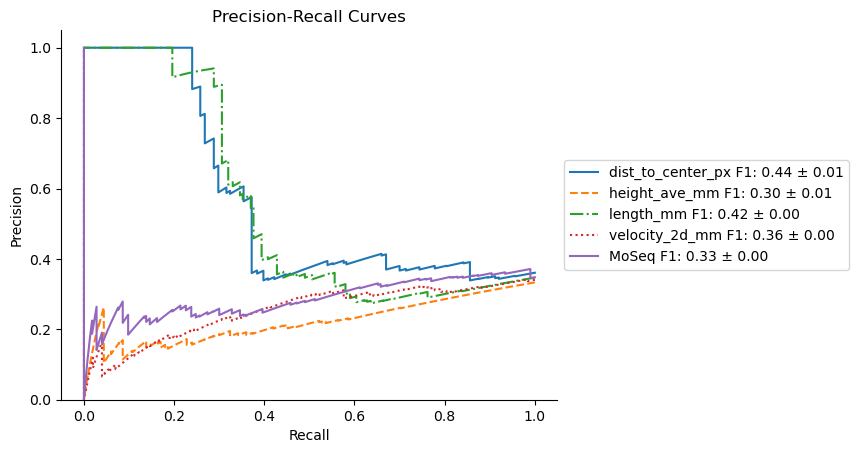

In [165]:
for feature_type in feature_types:
    label = make_label(feature_type)
    plot(recalls[feature_type], precisions[feature_type],
         label=label, color=feature_color[feature_type], 
         linestyle=feature_mark[feature_type])
title('Precision-Recall Curves')
xlabel('Recall')
ylabel('Precision')
ylim(0, 1.05)
legend(loc='center left', bbox_to_anchor=[1,0.5])
sns.despine()

## Cosine Distances Between Treatments

In [ ]:
cosine = lambda data: squareform(pdist(data,metric='cosine'))

def sim_matrix_of_avgs(data,labels):
    # Get the per-label average of the data
    unique_labels = np.unique(labels)
    out = np.zeros((len(unique_labels),len(unique_labels)),dtype='float32')
    means = np.zeros((len(unique_labels),data.shape[1]))
    for ilabel in unique_labels:
        means[ilabel] = np.nanmean(data[labels==ilabel],0)
    return cosine(means)

def show_cosine(data):
    return imshow(sim_matrix_of_avgs(data, fingerprint_labels['y_drug']),
                  cmap='viridis_r',
                  clim=(0,1.0),
                  interpolation=None); axis('square')


short_name_map = OrderedDict([
    ('alprazolam','ALPR'),
    ('atomoxetine','ATOM'),
    ('bupropion','BUPR'),
    ('chlorpromazine','CHLO'),
    ('citalopram','CITA'),
    ('clozapine','CLOZ'),
    ('control','CTRL'),
    ('diazepam','DIAZ'),
    ('fluoxetine','FLUO'),
    ('haloperidol','HALO'),
    ('methamphetamine','METH'),
    ('methylphenidate','MTPH'),
    ('modafinil','MODA'),
    ('phenelzine','PHEN'),
    ('risperidone','RISP'),
    ('venlafaxine','VENL'),
])
short_names = [short_name_map[u] for u in unique_labels]

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Cosine similarity function
cosine = lambda data: squareform(pdist(data, metric='cosine'))

def sim_matrix_of_avgs(data, labels):
    """Compute the cosine similarity matrix of averages for each label."""
    unique_labels = np.unique(labels)
    out = np.zeros((len(unique_labels), len(unique_labels)), dtype='float32')
    means = np.zeros((len(unique_labels), data.shape[1]))
    
    for i, ilabel in enumerate(unique_labels):
        means[i] = np.nanmean(data[labels == ilabel], axis=0)
    
    return cosine(means)

def show_cosine(data, labels):
    """Display the cosine similarity matrix for the given data and labels."""
    plt.imshow(sim_matrix_of_avgs(data, labels),
               cmap='viridis_r', clim=(0, 1.0), interpolation='none')
    plt.axis('square')
    plt.colorbar()
    plt.title('Cosine Similarity Matrix')
    plt.show()

# Feature types
feature_types = ['position', 'height', 'length', 'velocity', 'moseq']
unique_labels = ['NGH', 'LNB']  # Binary labels

# Example label mapping for binary classification
label_mapping = {'NGH': 0, 'LNB': 1}

# Map your labels to binary values
fingerprint_labels_binary = np.array([label_mapping[label] for label in fingerprint_labels['condition']])

# Example function to show cosine similarity for each feature type
def show_cosine_per_feature(fingerprint_data):
    """Plot cosine similarity for each feature type."""
    for feature_type in feature_types:
        print(f"Working on feature: {feature_type}")
        
        data = fingerprint_data[feature_type]  # Extract data for the current feature
        show_cosine(data, fingerprint_labels_binary)  # Plot cosine similarity for current feature

# Assuming `fingerprint_data` is a dictionary containing the data for each feature type
# fingerprint_data = {
#     'position': np.array([...]),  # Data for position
#     'height': np.array([...]),    # Data for height
#     'length': np.array([...]),    # Data for length
#     'velocity': np.array([...]),  # Data for velocity
#     'moseq': np.array([...])      # Data for moseq
# }

# Example call to visualize the cosine similarity for each feature
# show_cosine_per_feature(fingerprint_data)


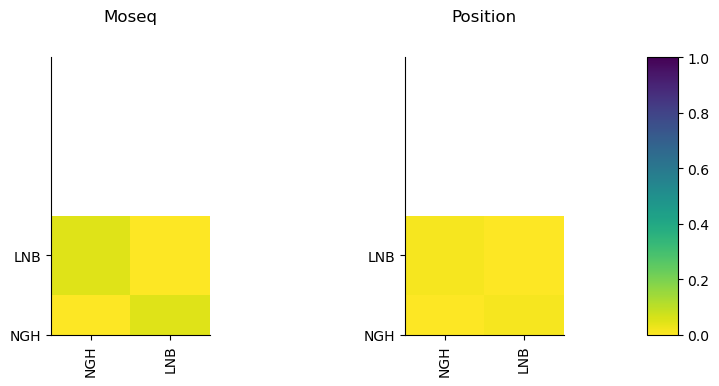

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy.spatial.distance import pdist, squareform

# Cosine similarity function
cosine = lambda data: squareform(pdist(data, metric='cosine'))

def sim_matrix_of_avgs(data, labels):
    """Compute the cosine similarity matrix of averages for each label."""
    unique_labels = np.unique(labels)
    means = np.zeros((len(unique_labels), data.shape[1]))
    
    for i, ilabel in enumerate(unique_labels):
        means[i] = np.nanmean(data[labels == ilabel], axis=0)
    
    return cosine(means)

def show_cosine(data, labels):
    """Display the cosine similarity matrix."""
    cos_matrix = sim_matrix_of_avgs(data, labels)
    cax = plt.imshow(cos_matrix, cmap='viridis_r', clim=(0, 1.0), interpolation='none')
    plt.axis('square')
    return cax

# Assuming 'fingerprints' is a dictionary containing the data matrices for 'moseq' and 'position'
# and 'fingerprint_labels_binary' contains your binary labels ['NGH', 'LNB']
fingerprint_data = {
    'MoSeq': fingerprints['MoSeq'],
    'dist_to_center_px': fingerprints['dist_to_center_px']
}

# Short names for the labels (NGH, LNB)
short_names = ['NGH', 'LNB']

# Plot configuration
plt.figure(figsize=(8, 4))
gs = GridSpec(1, 3, width_ratios=[10, 10, 0.8])

# First plot: Moseq feature
ax1 = plt.subplot(gs[0])
cax1 = show_cosine(fingerprint_data['MoSeq'], fingerprint_labels_binary)
plt.title('Moseq', y=1.1)
plt.xticks(range(len(short_names)), short_names, rotation=90)
plt.yticks(range(len(short_names)), short_names)
sns.despine()

# Second plot: Position feature
ax2 = plt.subplot(gs[1])
cax2 = show_cosine(fingerprint_data['dist_to_center_px'], fingerprint_labels_binary)
plt.title('Position', y=1.1)
plt.xticks(range(len(short_names)), short_names, rotation=90)
plt.yticks(range(len(short_names)), short_names)
sns.despine()

# Colorbar
ax3 = plt.subplot(gs[2])
plt.colorbar(cax2, cax=ax3)

plt.tight_layout()
plt.show()


Working on velocity_2d_mm


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 281.21it/s]


Working on dist_to_center_px


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 301.36it/s]


Working on height_ave_mm


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 259.77it/s]


Working on length_mm


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 317.76it/s]


Working on MoSeq


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 250.90it/s]


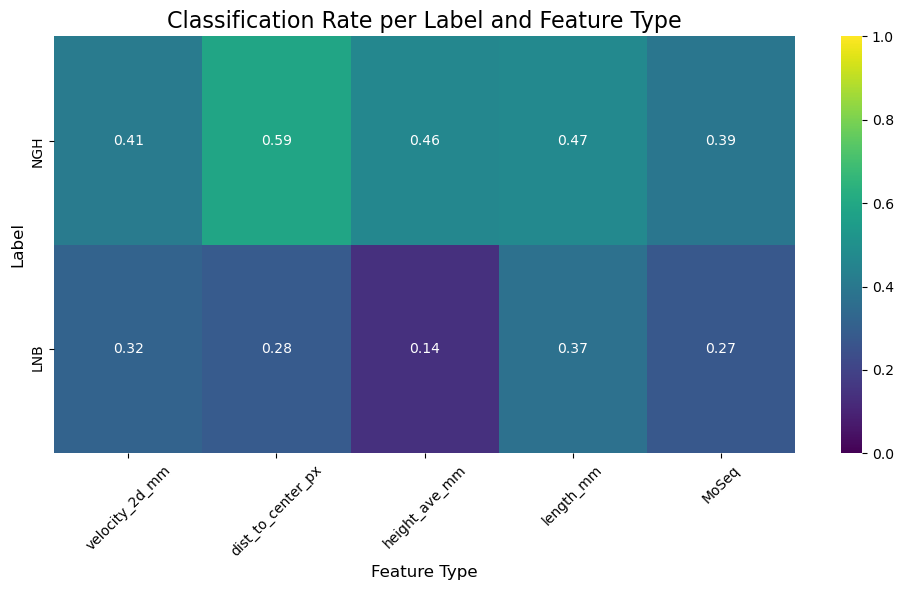

In [172]:
import numpy as np
from sklearn.metrics import f1_score
from collections import OrderedDict

# Initialize dictionaries to store results
classification_rates = OrderedDict()

label_mapping = {'LNB': 0, 'NGH': 1}  # Map 'LNB' to 0, 'NGH' to 1

# Feature types and labels for NGH/LNB
feature_types = ['velocity_2d_mm', 'dist_to_center_px', 'height_ave_mm', 'length_mm', 'MoSeq']
labels = ['NGH', 'LNB']

# Prepare a matrix to store F1 scores for each feature and label
classification_matrix = np.zeros((len(labels), len(feature_types)))

for j, feature_type in enumerate(feature_types):
    print(f'Working on {feature_type}')

    # Get data for the current feature type
    x = fingerprints[feature_type]
        
    all_true_labels = []
    all_scores = []
    f1s_per_label = []  # Store F1 scores for NGH and LNB

    # Train a separate classifier for each feature type across multiple seeds
    for iseed in trange(n_samples):
        true_labels, pred_labels, scores = train_linear_classifier(x, y, seed=iseed)
        
        # Ensure true_labels is treated as a numpy array
        true_labels = np.array(true_labels)
        
        # Replace 'LNB' with 0 and 'NGH' with 1 in true labels
        true_labels = np.array([label_mapping[label] for label in true_labels])

        # Ensure pred_labels are also mapped to 0 and 1 using label_mapping
        pred_labels = np.array([label_mapping[label] for label in pred_labels])

        # Accumulate true labels and predictions across seeds
        f1_per_seed = f1_score(true_labels, pred_labels, average=None)  # Get F1 for each class
        f1s_per_label.append(f1_per_seed)  # Append F1 scores for NGH and LNB
    
    # Average the F1 scores across seeds for each class
    f1s_per_label = np.mean(f1s_per_label, axis=0)

    # Store the F1 scores for NGH and LNB in the classification matrix
    for i, label in enumerate(labels):
        classification_matrix[i, j] = f1s_per_label[i]  # Store F1 score for NGH and LNB

# Now create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(classification_matrix, annot=True, cmap='viridis', xticklabels=feature_types, yticklabels=labels, cbar=True, vmin=0, vmax=1)

# Customize the plot
plt.title('Classification Rate per Label and Feature Type', fontsize=16)
plt.xlabel('Feature Type', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


## LDA Visualization of Mice Across Treatments

In [11]:
lda = LinearDiscriminantAnalysis(n_components=2).fit(fingerprints['moseq'], fingerprint_labels['y_drug'])
p = lda.transform(fingerprints['moseq'])

In [12]:
drug_class = fingerprint_labels['drug_class']
unique_class = [b for a,b in zip([""]+drug_class,drug_class) if b!=a]
drug = fingerprint_labels['drug']
unique_drug = [b for a,b in zip([""]+drug,drug) if b!=a]

In [13]:
color_map = dict(zip(unique_class, sns.color_palette(palette='Paired', n_colors=len(unique_class))))
class_per_drug = []

colors_ = []
for drug_ in unique_drug:
    class_ = np.array(drug_class)[np.array(drug)==drug_][0]
    colors_.append(color_map[class_])

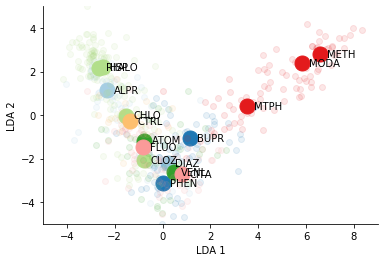

In [14]:
for i, treatment in enumerate(unique_drug):
    idx = fingerprint_labels['y_drug'] == i
    plot(p[idx, 0], p[idx, 1], 'o', alpha=0.1, color=colors_[i])
    x, y = np.mean(p[idx], axis=0)
    plot(x, y, 'o',
         markersize=15, color=colors_[i], label=short_name_map[treatment])
    text(x + 0.3, y, short_name_map[treatment], fontsize=10, verticalalignment='center', )
    
sns.despine()
ylim(-5, 5)
xlim(-5, 9)
xlabel('LDA 1')
ylabel('LDA 2');